In [27]:

import pandas as pd
import numpy as np
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


In [28]:
#Chatgpt generated rencoding of data

import pandas as pd
import numpy as np
import re
import statsmodels.api as sm

# Load CSV
#file_path = "/mnt/data/Sec001_ckd_dataset_v2 (1).csv"
df = pd.read_csv("kidney.csv")


# Columns to analyze
cols_to_check = ["sg", "al", "su", "bgr", "bu", "sod", "sc", "pot", "hemo", "pcv", "rbcc", "wbcc", "grf", "age"]

# Function to extract numeric bounds
def parse_range(value, col_min=None, col_max=None):
    if pd.isna(value):
        return (np.nan, np.nan)
    value = str(value).strip()
    
    # Range format (e.g., "1 - 1" or "1.009 - 1.011")
    if "-" in value:
        nums = re.findall(r"[\d.]+", value)
        if len(nums) == 2:
            low, high = map(float, nums)
            return (low, high)
    
    # Greater than or equal (e.g., "≥ 4")
    elif "≥" in value:
        num = float(re.findall(r"[\d.]+", value)[0])
        return (num, col_max if col_max is not None else num)
    
    # Less than (e.g., "<3")
    elif "<" in value:
        num = float(re.findall(r"[\d.]+", value)[0])
        return (col_min if col_min is not None else 0, num)
    
    # Plain numeric
    elif re.match(r"^[\d.]+$", value):
        num = float(value)
        return (num, num)
    
    # Fallback for unknown formats
    return (np.nan, np.nan)

# Print unique values for each column
for col in cols_to_check:
    print(f"\n--- Unique values in {col} ---")
    print(df[col].dropna().unique())

# Apply parsing and create two new columns for each target column
for col in cols_to_check:
    # Compute overall numeric min and max ignoring non-numeric entries
    numeric_values = df[col].astype(str).str.extract(r"([\d.]+)").dropna()[0].astype(float)
    col_min, col_max = numeric_values.min(), numeric_values.max()
    
    parsed = df[col].apply(lambda x: parse_range(x, col_min, col_max))
    df[f"{col}_low"] = parsed.apply(lambda x: x[0])
    df[f"{col}_high"] = parsed.apply(lambda x: x[1])

#recode class, stage
df["classbinom"] = (df["class"] == "ckd").astype(int)
df['stagenum'] = df['stage'].astype("category").cat.codes

# Preview the result


df = df.drop(0, axis = 0)
df = df.drop(1, axis = 0)
df = df.drop(columns = ["sg", "al", "su", "bgr", "bu", "sod", "sc", "pot", "hemo", "pcv", "rbcc", "wbcc", "grf", "age", 'class', 'stage'])
df = df.dropna()
df.head()




--- Unique values in sg ---
['discrete' '1.019 - 1.021' '1.009 - 1.011' '1.015 - 1.017' '≥ 1.023'
 '< 1.007']

--- Unique values in al ---
['discrete' '1 - 1' '< 0' '≥ 4' '3 - 3' '2 - 2']

--- Unique values in su ---
['discrete' '< 0' '4 - 4' '2 - 2' '3 - 4' '1 - 2' '≥ 4']

--- Unique values in bgr ---
['discrete' '< 112' '112 - 154' '154 - 196' '406 - 448' '238 - 280'
 '196 - 238' '≥ 448' '280 - 322' '364 - 406' '322 - 364']

--- Unique values in bu ---
['discrete' '< 48.1' '48.1 - 86.2' '200.5 - 238.6' '124.3 - 162.4'
 '86.2 - 124.3' '162.4 - 200.5' '≥ 352.9' '238.6 - 276.7']

--- Unique values in sod ---
['discrete' '138 - 143' '133 - 138' '123 - 128' '143 - 148' '148 - 153'
 '< 118' '128 - 133' '118 - 123' '≥ 158']

--- Unique values in sc ---
['discrete' '< 3.65' '3.65 - 6.8' '16.25 - 19.4' '6.8 - 9.95'
 '13.1 - 16.25' '9.95 - 13.1' '≥ 28.85']

--- Unique values in pot ---
['discrete' '< 7.31' '≥ 42.59' '7.31 - 11.72' '38.18 - 42.59']

--- Unique values in hemo ---
['discrete' '1

,bp (Diastolic),bp limit,rbc,pc,pcc,ba,htn,dm,cad,appet,...,rbcc_low,rbcc_high,wbcc_low,wbcc_high,grf_low,grf_high,age_low,age_high,classbinom,stagenum
2,0,0,0,0,0,0,0,0,0,0,...,4.46,5.05,7360.0,9740.0,227.944,227.944,12.0,12.0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,4.46,5.05,12120.0,14500.0,227.944,227.944,12.0,12.0,1,1
4,0,0,1,1,0,1,0,0,0,1,...,4.46,5.05,14500.0,16880.0,127.281,152.446,12.0,12.0,1,1
5,1,1,0,0,0,0,0,0,0,0,...,4.46,5.05,7360.0,9740.0,127.281,152.446,12.0,12.0,1,1
6,0,0,0,0,0,0,0,1,0,1,...,5.05,5.64,7360.0,9740.0,127.281,152.446,12.0,20.0,1,1


In [16]:
y = df['classbinom']
X = df.drop(columns=["classbinom"]).select_dtypes(include=["number"])
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             classbinom   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     23.57
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           8.28e-45
Time:                        21:41:07   Log-Likelihood:                 21.249
No. Observations:                 199   AIC:                             15.50
Df Residuals:                     170   BIC:                             111.0
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.3324      5.019      4.649      0.0

In [17]:
y = df['classbinom']
X = df.drop(columns = ['classbinom','stagenum','affected'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=381)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:

alpha_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]}

lasso_base = Lasso(random_state=381)


grid_lasso = GridSearchCV(lasso_base,alpha_grid,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)

grid_lasso.fit(X_train_scaled, y_train)

print("Best alpha:", grid_lasso.best_params_['alpha'])
best_lasso = grid_lasso.best_estimator_

# Predict using best model
lasso_pred = (best_lasso.predict(X_test_scaled) > 0.5).astype(int)
lasso_acc = accuracy_score(y_test, lasso_pred)

print("LASSO Accuracy:", lasso_acc)


/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.996e-02, tolerance: 2.920e-03
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e-02, tolerance: 2.920e-03
  model = cd_fast.enet_coordinate_descent(


Best alpha: 0.01
LASSO Accuracy: 0.96


Accuracy: 0.96


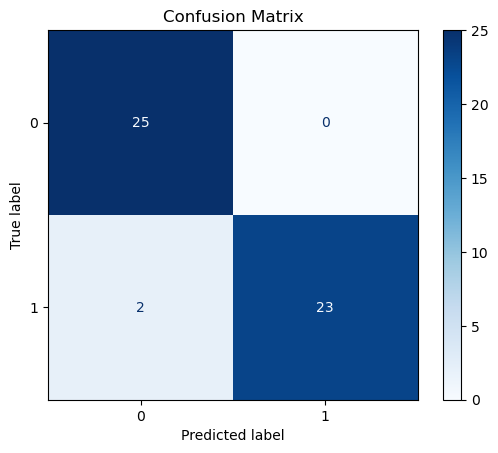

In [50]:
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


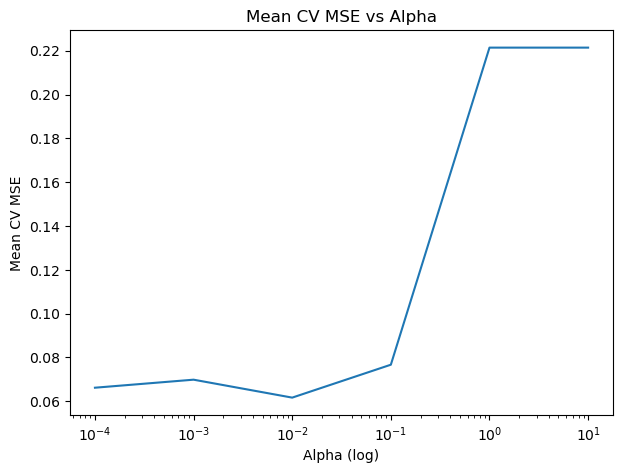

In [63]:
results = pd.DataFrame(grid_lasso.cv_results_)

alphas = results['param_alpha'].astype(float)
mean_mse = -results['mean_test_score']  

plt.figure(figsize=(7,5))
plt.plot(alphas, mean_mse)
plt.xscale('log')
plt.xlabel("Alpha (log)")
plt.ylabel("Mean CV MSE")
plt.title("Mean CV MSE vs Alpha")

best_alpha = grid_lasso.best_params_['alpha']

plt.show()

In [10]:
rf = RandomForestClassifier(n_estimators = 500, max_depth=None, min_samples_split=2, random_state=42)

In [11]:
rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
rf_preds = rf.predict(X_test)
rf_acc = (accuracy_score(y_test, rf_preds))

In [25]:
print("Random Forest Test Accuracy:", round(rf_acc, 4))

Random Forest Test Accuracy: 0.98


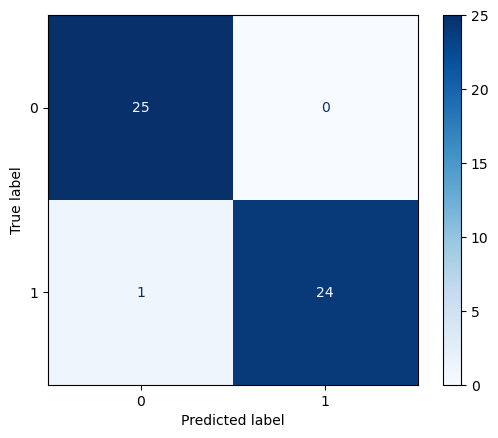

In [37]:
cm = confusion_matrix(y_test, rf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = "Blues")

In [38]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
estimator = rf.estimators_[0]

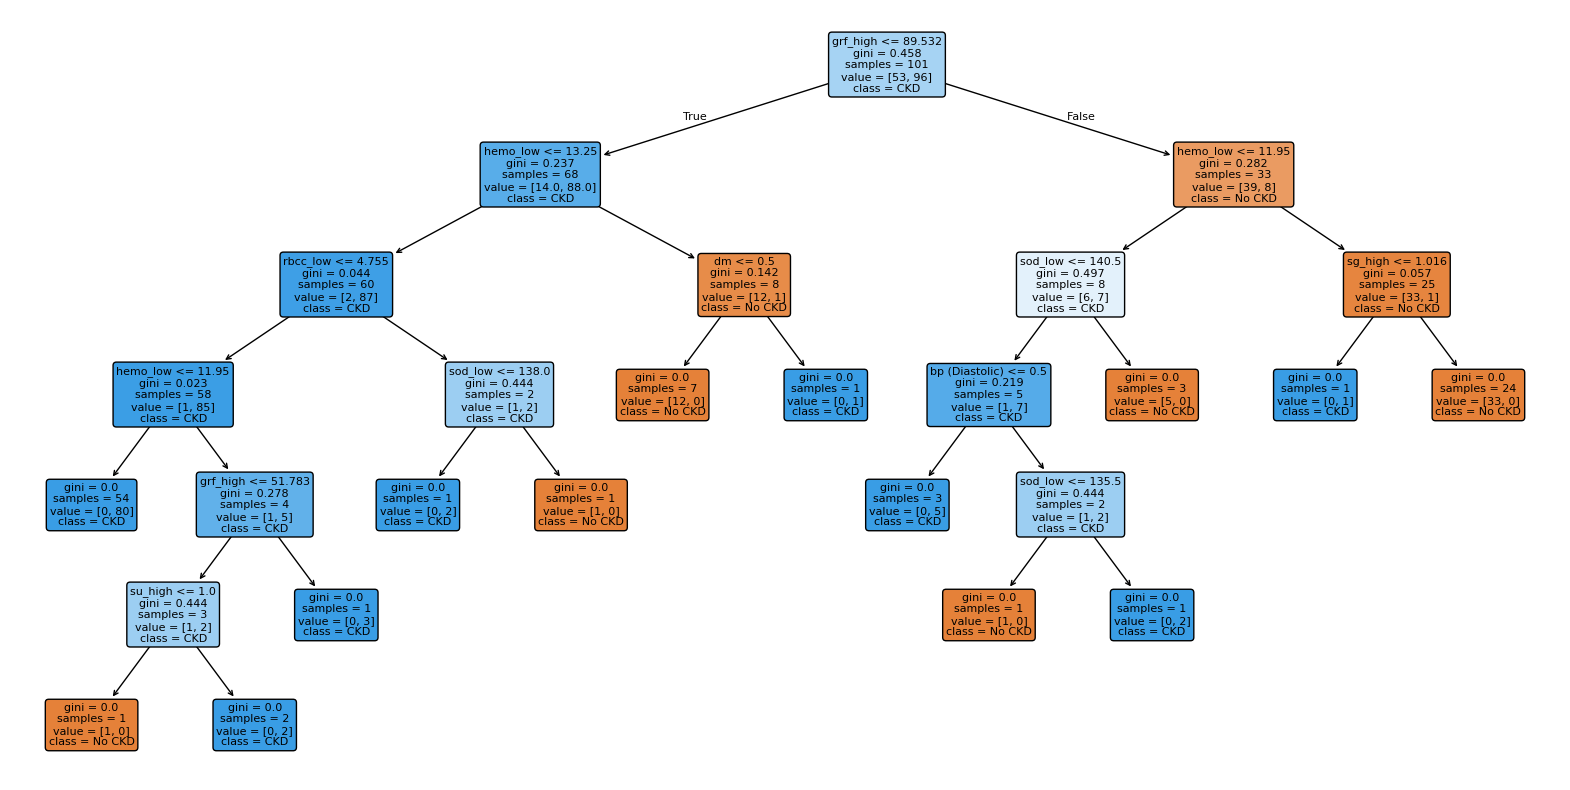

In [40]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    estimator,
    feature_names=X.columns,
    class_names=["No CKD", "CKD"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()

In [58]:
param_grid = {'max_depth': [3, 5, 10, 20]}

rf_base = RandomForestClassifier(n_estimators=300,random_state=381)

grid = GridSearchCV(rf_base,param_grid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
best_rf = grid.best_estimator_

rf_pred = best_rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

print("Random Forest Accuracy:", rf_acc)

Best parameters: {'max_depth': 5}
Random Forest Accuracy: 0.96


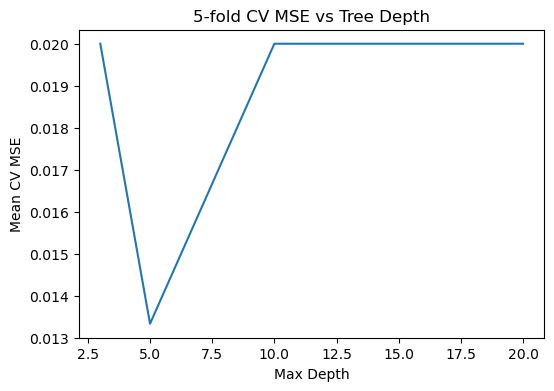

In [62]:
cv_results = pd.DataFrame(grid.cv_results_)

depths = [3, 5, 10, 20]
mse_scores = []

for d in depths:
    neg_mse = cv_results.loc[
        cv_results["param_max_depth"] == d,
        "mean_test_score"
    ].values[0]
    
    mse = -neg_mse   
    mse_scores.append(mse)

plt.figure(figsize=(6,4))
plt.plot(depths, mse_scores)
plt.xlabel("Max Depth")
plt.ylabel("Mean CV MSE")
plt.title("5-fold CV MSE vs Tree Depth")


plt.show()

